In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(word) for word in words))
print(words[:10])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [25]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)   
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])    
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [26]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:    
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __init__(self):
        pass
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [27]:
torch.manual_seed(42)

In [28]:
n_emb = 10
n_hidden = 200
C = torch.randn((vocab_size, n_emb)) 
layers = [
    Linear(n_emb*block_size, n_hidden, bias= False), Tanh(),
    Linear(n_hidden, vocab_size)
]
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11697


In [29]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2960
  10000/ 200000: 2.2138
  20000/ 200000: 2.3725
  30000/ 200000: 1.9389
  40000/ 200000: 2.3105
  50000/ 200000: 2.2860
  60000/ 200000: 1.9289
  70000/ 200000: 1.9856
  80000/ 200000: 2.6718
  90000/ 200000: 2.0075
 100000/ 200000: 2.2656
 110000/ 200000: 1.5968
 120000/ 200000: 2.2204
 130000/ 200000: 2.1780
 140000/ 200000: 1.8482
 150000/ 200000: 1.8711
 160000/ 200000: 1.8569
 170000/ 200000: 2.2315
 180000/ 200000: 1.9473
 190000/ 200000: 2.2746


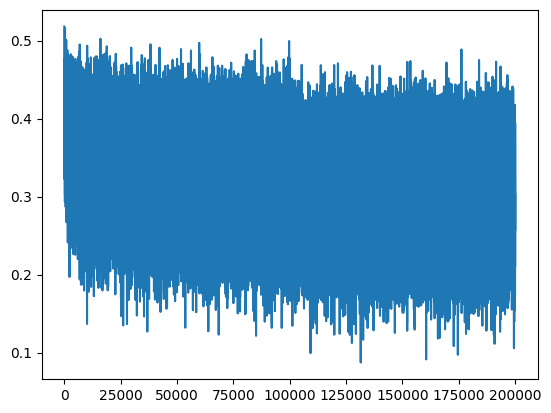

In [30]:
plt.plot(lossi)

In [31]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False

In [32]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())
    
split_loss("train")
split_loss("val")

train 2.0398991107940674
val 2.1048905849456787


In [33]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

damiara.
alyza.
pos.
tri.
gerrynlis.
sayvon.
luna.
sophette.
catine.
aub.
alitithira.
liza.
jah.
grancealyiah.
jamaurito.
farabeth.
mim.
kaia.
cer.
tyre.


fixing learning rate plot

In [34]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

In [36]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

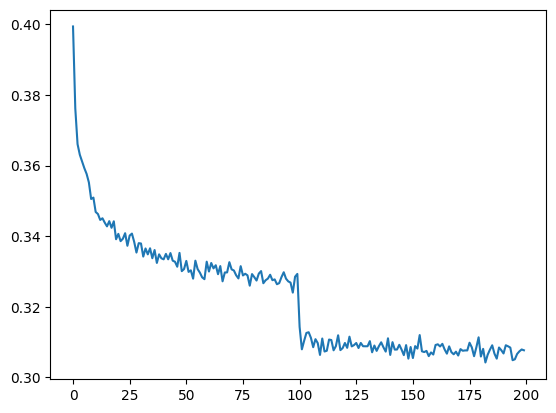

In [37]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.show()

In [ ]:
# pytorchifying the emdding layer also

In [38]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:    
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __init__(self):
        pass
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

In [39]:
n_emb = 10
n_hidden = 200

layers = [
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(n_emb*block_size, n_hidden, bias= False), Tanh(),
    Linear(n_hidden, vocab_size)
]
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident
    
parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11697


In [40]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.2930


In [9]:
# pytorch containers
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:    
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __init__(self):
        pass
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all the layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [15]:
torch.manual_seed(42)

In [17]:
n_emb = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(n_emb*block_size, n_hidden, bias= False), Tanh(),
    Linear(n_hidden, vocab_size)
])
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

21697


In [18]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3064


In [19]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [20]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss("train")
split_loss("val")

train 3.1241838932037354
val 3.1233315467834473


In [21]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

y.
epkoi.
zreefwgavnojmbb.
knmclc.
rej.
eeeebsrzpyshrarpiijbmifgtlkwrb.
aynhrmlwbuqzbwwrfuepuvryblkyjx.
yiidx.
gge.
yysqxlkhqtxwpebehgtqx.
kaftinjkfsklgkjhkqngyincigwaevrgmtnnmiq.
ifhkvqxarlvsjaajklxazefwbjzqcad.
ivtewotyfwlzqhto.
onmefxwsuike.
igogxrosvliqkudndkzhpvpnszcwzgjo.
hyjlqtgsh.
ytkfngvwjbnfnzjbgewsejsbnbfuuxtmgdaggb.
bplewyg.
.
eagwuoc.


In [49]:
# building wavenet

In [22]:
block_size = 8

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)   
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])    
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [23]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [24]:
torch.manual_seed(42)

In [25]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [26]:
## scratch space for playing

In [27]:
Xtr.shape

torch.Size([182625, 8])

In [28]:
ix

0

In [30]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 14, 15, 24],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1, 13,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [31]:
model.layers[0].out.shape # output of embedding layer

torch.Size([4, 8, 10])

In [32]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [33]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [34]:
(torch.randn(4,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [35]:
# matrix mutliplication works with any dimension
(torch.randn(4,5,6,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

In [36]:
# this is helpful to us because we have:
# 1 2 3 4 5 6 7 8
# and we want to group them
# (1 2) (3 4) (5 6) (7 8)

# we don't want 80 to feed in but want to feed these groups of 4 , so it will from 20 such groups (80/4)

(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [37]:
# need to change the behaviour of flatten layer, we need to make it output 4, 4, 20

In [38]:
e = torch.randn(4, 8, 10) # this is input to flatten layer, and it fatten that 10 d values of 8 resulting in 10*8
# i.e
e.view(4, -1).shape

torch.Size([4, 80])

In [44]:
# we instead want it to be 4,4,20  where consecutive 10d vectors get concatenated not all
# one way to do is
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
# take even, odd and concatenate them
explicit.shape

torch.Size([4, 4, 20])

In [40]:
e[:, ::2, :].shape

torch.Size([4, 4, 10])

In [41]:
e.shape

torch.Size([4, 8, 10])

In [43]:
# other way
e.view(4, 4, 20).shape

torch.Size([4, 4, 20])

In [45]:
(e.view(4,4,20) == explicit).all()

tensor(True)

In [52]:
# let's implement this:
# pytorch containers
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:    
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __init__(self):
        pass
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    # this will flatten some "n" consecutive inputs
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all the layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [47]:
torch.manual_seed(42)

In [53]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size),
    Linear(n_embd*block_size, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [54]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  8, 21,  4],
        [ 0,  5, 13,  1, 14, 21,  5, 12],
        [ 0,  0,  1, 18,  1,  3,  5, 12],
        [ 0,  0,  0,  0,  0,  0,  0,  4]])

In [55]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [56]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


In [69]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 0,  0,  0,  0,  0,  1,  4,  1],
        [ 0,  0,  0, 11,  9, 14,  7, 13]])

In [58]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [59]:
logits.shape

torch.Size([4, 27])

In [72]:
# fixing batchnorm
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training: 
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __init__(self):
        pass
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    # this will flatten some "n" consecutive inputs
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all the layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [73]:
torch.manual_seed(42)

In [74]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [76]:
model.layers[3].running_mean.shape

torch.Size([68])

In [78]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.1741
  10000/ 200000: 2.0153
  20000/ 200000: 2.2218
  30000/ 200000: 2.5235
  40000/ 200000: 2.0925
  50000/ 200000: 2.0215
  60000/ 200000: 1.6978
  70000/ 200000: 1.9231
  80000/ 200000: 2.3432
  90000/ 200000: 2.2999
 100000/ 200000: 1.9161
 110000/ 200000: 1.8695
 120000/ 200000: 1.7327
 130000/ 200000: 1.9107
 140000/ 200000: 1.6832
 150000/ 200000: 1.9177
 160000/ 200000: 2.1522
 170000/ 200000: 1.7957
 180000/ 200000: 2.2514
 190000/ 200000: 2.5035


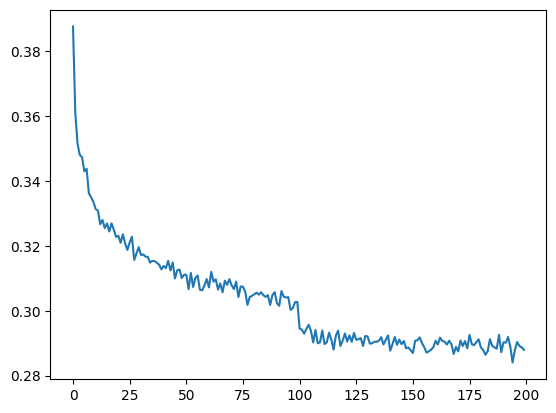

In [79]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.show()

In [80]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss("train")
split_loss("val")

train 1.9183603525161743
val 2.020085334777832


In [81]:
# scaling up our wavenet

In [82]:
torch.manual_seed(42)

n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias= False),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
# training this will take a lot more longer

76579
